## **3 方法**

在本节中，我们介绍了掩码模态投影（$\mathbf{MMP}$），这是一种新颖的方法，用于训练一个对缺失模态具有鲁棒性的单一多模态模型。在这种方法中，每个训练迭代中都会随机掩码出一部分模态。为了解决这些模态缺失的问题，我们引入了投影函数，这些函数学习将可用模态的标记映射到缺失模态的标记，我们称之为投影标记。这些投影标记使用对齐损失目标与实际标记进行对齐。最后，将投影标记传递给对应于掩码模态的分支。



### **3.1 模态掩码**

模态掩码是我们MMP方法的关键组成部分。如第2节所述，模态丢弃增强（modality dropout augmentation），即随机将模态置零，已显示出对缺失模态的鲁棒性。我们通过在每个训练迭代中掩码出随机子集的所有标记来扩展这个想法。我们不直接输入零，而是使用可用模态来预测掩码模态的标记。具体来说，在每个迭代中，随机选择一个子集的模态进行掩码（即不将其输入模型）。我们的目标是训练模型使用可用模态预测掩码模态的标记。



### **3.2 模态投影**

我们提出了一种模态投影方法，用于掩码$\bar{\text{模态 }i}$，如图2所示。假设我们有$M$个不同的模态作为输入。嵌入层从每个输入模态生成标记，如公式（1）所示：
$$\mathbf{T}_i=\text{EmbeddingLayer}(\mathbf{I}_i),$$
其中，$\mathbf{I}_i$表示输入模态$i\in\{1,2,\ldots,M\}$，$\boldsymbol{\Gamma}_i\in\mathbb{R}^{N\times d}$表示模态$i$的标记，$N$是标记的数量，$d$是嵌入维度。为了简单起见，这里我们假设$N$和$d$在所有模态中都是相同的。我们将在第3.3节讨论如何扩展我们的方法以处理模态之间标记数量和嵌入维度不同的情况。

我们引入了投影函数$f_i$来预测掩码模态$i$的标记。这个过程从利用聚合标记开始。受Mo和Morgado（2024）的启发，聚合标记将模态信息总结为一种紧凑的表示形式，从而减少了与大量模态标记相关的计算和存储复杂性。对于每个模态$i$，我们使用八个聚合标记$\overline{\mathbf{T}}_i$，随机初始化为可学习参数。当模态$j$在迭代中可用时，它的聚合标记$\overline{\mathrm{T}}_j$通过使用多头交叉注意力来关注实际模态标记$\mathbf{T}_j$进行更新。这个过程如公式（2）所示：
$$\begin{aligned}\overline{\mathbf{T}}_{j}&=\text{CrossAttention}\left(\overline{\mathbf{T}}_j,\mathbf{T}_j\mid j\in\mathcal{A}\right),\\&=\mathrm{softmax}\left(\frac{\overline{\mathbf{T}}_j\mathbf{W}_\mathrm{q}\mathbf{W}_\mathrm{k}^\top\mathbf{T}_j^\top}{\sqrt{d}}\right)\mathbf{T}_j\mathbf{W}_\mathrm{v},\end{aligned}$$
其中，$\mathrm{T}_j\in\mathbb{R}^{N\times d}$和$\overline{\mathbf{T}}_j\in\mathbb{R}^{8\times d}$分别表示模态$j$的标记和聚合标记，$\mathcal{A}$是可用模态的集合。$\mathbf{W}_{\mathrm{q}},\mathbf{W}_{\mathrm{k}}$和$\mathbf{W}_\mathrm{v}$分别是查询、键和值投影的可学习权重矩阵。只有当模态可用时才更新聚合标记；如果模态$i$在迭代中被掩码，它的聚合标记$\overline{\mathbf{T}}_i$保持不变。

当处理缺失模态时，对于每个缺失（在训练期间被掩码）的模态$i$，分别对缺失模态的聚合标记和每个可用模态的聚合标记进行交叉注意力。这一步捕捉了缺失模态和每个可用模态之间的关系，使模型能够基于可用数据来近似缺失模态的信息。具体来说，如公式（3）所示：
$$\mathbf{X}_{ij}=\text{CrossAttention}(\overline{\mathbf{T}}_i,\overline{\mathbf{T}}_j),$$
其中，$\overline{\mathbf{T}}_i,\overline{\mathbf{T}}_j$分别是缺失模态$i$和可用模态$j$的聚合标记。$\mathbf{X}_{ij}$表示与缺失模态$i$相关的可用模态$j$的关注标记。

然后，我们利用$\mathbf{X}_{ij}$与可用模态$j$的原始标记$\mathbf{T}_j$进行交叉注意力，以确保关系信息与每个可用模态的具体特征相结合。细化过程如公式（4）所示：
$$\mathbf{T}_{\text{attended}_j}=\text{CrossAttention}(\mathbf{T}_j,\mathbf{X}_{ij}),$$
其中，$\mathrm{T}_{\mathrm{attended}_{j}}$表示可用模态$j$的细化关注标记。然后，将每个可用模态$j$的细化关注标记连接起来，如公式（5）所示：
$$\mathrm{T}_{\mathrm{available}}=\mathrm{Concat}\left(\{\mathrm{T}_{\mathrm{attended}_j}\mid j\in\mathcal{A}\}\right),$$
其中，$\mathcal{A}$表示可用模态的集合。连接后的标记$\mathrm{T}_{\mathrm{available}}$然后被输入到一个多层感知机（MLP）中，以生成缺失模态$i$的投影标记$\mathrm{T}_i'$，如公式（6）所示：
$$\mathrm{T}_i' = \text{MLP}(\mathrm{T}_{\mathrm{available}}).$$

缺失模态的标记被其对应的投影标记$\mathrm{T}_i'$替换，并传递到网络中的相应分支。


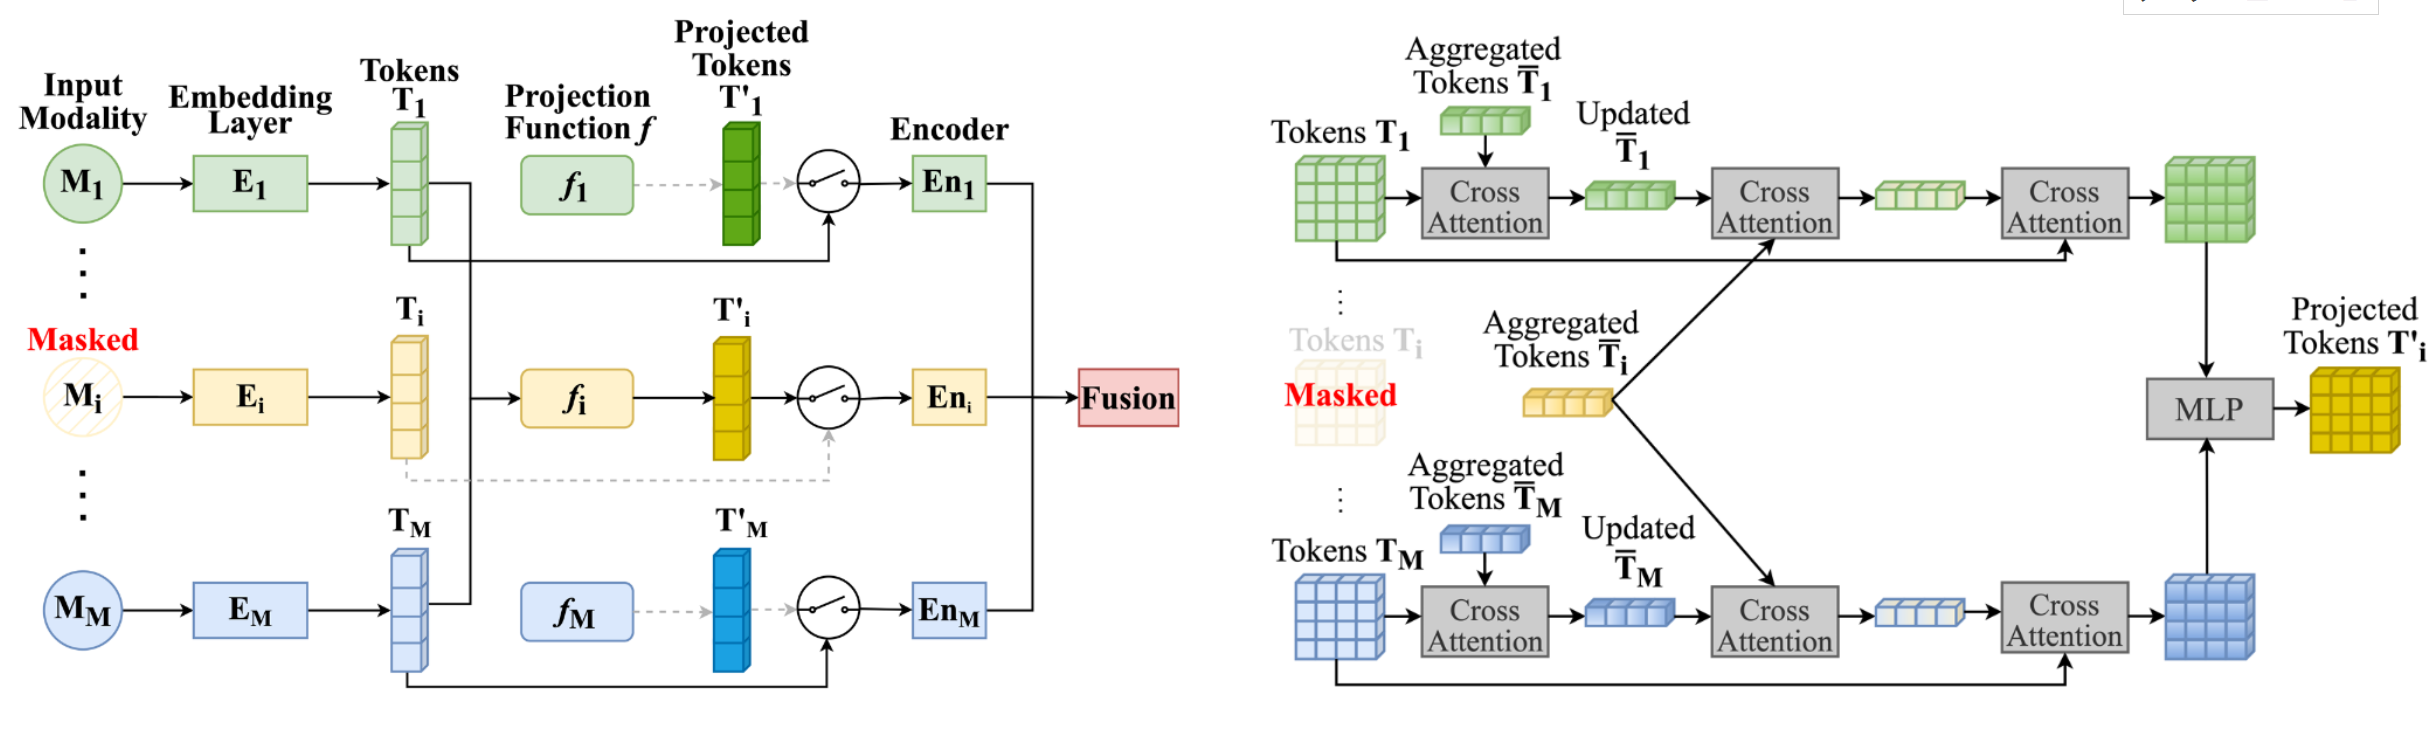

---
- 可用模态的标记通过 **交叉注意力**（cross-attention）机制进行处理，以更新其聚合标记。这一步的目的是让可用模态的标记能够相互“理解”并进行信息整合。
- 更新后的聚合标记与掩码模态的标记通过另一步 **交叉注意力** 进行组合。这一步旨在将可用模态的信息与掩码模态的信息进行关联，即使掩码模态的信息在训练过程中被隐藏，模型仍能通过可用模态的信息来推测其内容。
- 通过上述步骤得到的跨模态关系被用来关注可用模态的实际标记。这一步的目的是让模型能够利用可用模态的信息来更好地估计掩码模态的内容。
- 最终的输出标记通过一个 **多层感知机（MLP）** 来生成掩码模态的投影标记。MLP将整合后的信息进行进一步处理，以生成能够代表掩码模态内容的标记。
---


### **3.3 标记与维度变化性**

我们的方法也适用于标记数量 $N$ 或嵌入维度 $d$ 在不同模态之间存在差异的情况。为了解决嵌入维度上的差异，我们在投影过程的开始应用一个线性层，将每个模态的标记映射到一个公共的嵌入维度。对于标记数量不同的情况，我们在 MLP 模块内合并一个线性层，以使投影标记 $\mathbf{T}_i^{\prime}$ 的标记数量与缺失模态 $i$ 的标记数量对齐。



### **3.3 标记与维度变化性**

我们的方法也适用于标记数量 $N$ 或嵌入维度 $d$ 在不同模态之间存在差异的情况。为了解决嵌入维度上的差异，我们在投影过程的开始应用一个线性层，将每个模态的标记映射到一个公共的嵌入维度。对于标记数量不同的情况，我们在 MLP 模块内合并一个线性层，以使投影标记 $\mathbf{T}_i^{\prime}$ 的标记数量与缺失模态 $i$ 的标记数量对齐。



### **3.4 对齐损失目标**

为了最小化投影标记和真实标记之间的差异，我们使用一个对齐损失目标，以确保投影标记与它们对应的真实标记紧密匹配。如果 $N_\mathrm{masked}$ 表示在一次迭代中掩码模态的数量，对齐损失计算如下：

$$\mathcal{L}_{\text{alignment}}=\frac{1}{N_{\text{masked}}}\sum_{i\in\text{masked}}\mathcal{L}_{\text{alignment}_i}(\mathbf{T}_i^{\prime},\mathbf{T}_i),$$

其中，$\mathcal{L}_{\text{alignment}_i}$ 表示真实标记 $\mathbf{T}_i$ 和投影标记 $\mathbf{T}_i^{\prime}$ 之间的平滑 L1 损失。为了将对齐损失合并到整体优化中，我们将其添加到网络的主要损失函数中：

$$\mathcal{L}_{\mathrm{total}}=\mathcal{L}_{\mathrm{task}}+\mathcal{L}_{\mathrm{alignment}}$$

（8）

其中，$\mathcal{L}_\mathrm{task}$ 表示网络的主要任务特定损失。